In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
import tensorflow
import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pickle
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn import metrics
import seaborn as sns

## Load the Dataset

In [3]:
paths = []
labels = []
for dirname, _, filenames in os.walk('./TESS_Dataset/TESS Toronto emotional speech set data/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        label = label.lower()
        labels.append(label)

print("Dataset is loaded")

Dataset is loaded


In [4]:
paths[:5]

['./TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_thin_angry.wav',
 './TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_deep_angry.wav',
 './TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_pole_angry.wav',
 './TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_lid_angry.wav',
 './TESS_Dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_match_angry.wav']

In [5]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

## Create a DataFrame 

In [6]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,./TESS_Dataset/TESS Toronto emotional speech s...,angry
1,./TESS_Dataset/TESS Toronto emotional speech s...,angry
2,./TESS_Dataset/TESS Toronto emotional speech s...,angry
3,./TESS_Dataset/TESS Toronto emotional speech s...,angry
4,./TESS_Dataset/TESS Toronto emotional speech s...,angry


In [7]:
df['label'].value_counts()

angry      400
sad        400
fear       400
disgust    400
neutral    400
happy      400
ps         400
Name: label, dtype: int64

## Exploratory Data Analysis

<AxesSubplot: xlabel='label', ylabel='count'>

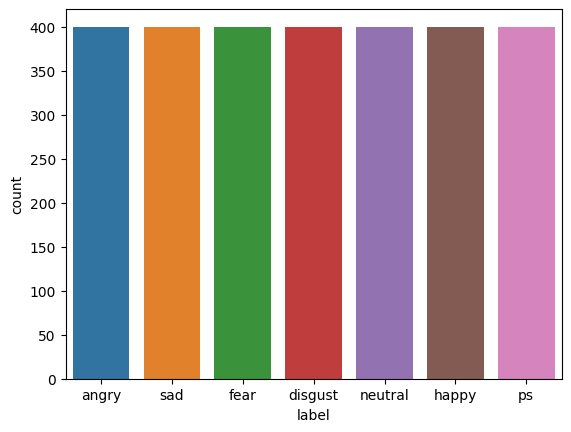

In [8]:
sns.countplot(x="label",data=df)

In [9]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
path

'./TESS_Dataset/TESS Toronto emotional speech set data/YAF_fear/YAF_white_fear.wav'

## Data Preprocessing

In [10]:
X = []
Y = []

In [11]:
def get_log_mel_spectrogram(path, n_fft, hop_length, n_mels):
    """
    Extract log mel spectrogram
        1) The length of the raw audio used is 8s long,
        2) and then get the MelSpectrogram,
        2) finally perform logarithmic operation to MelSpectrogram.
    Return:
        log_mel_spectrogram:
    """
    y, sr = librosa.load(path)

    file_length = np.size(y)
    """
     3 is the duration of each file.
    """
    if file_length != sr*3:
        y = np.concatenate((y, np.zeros(sr*3-file_length)), axis=0)

    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)

    return log_mel_spectrogram


In [12]:
def get_data(paths):
    for i in range(len(paths)):
        if i%50==0:
            print("i= ",i)
        path = paths[i]
        data = get_log_mel_spectrogram(path,n_fft=2048, hop_length=512, n_mels=128)
        X.append(data)
        Y.append(labels[i])

In [ ]:
get_data(paths)

In [ ]:
print(len(X),len(Y))
print(X[0].shape)

## Visualizing the spectogram

In [24]:
def display_spectogram(X):
    randomIndexes = np.random.randint(1,2821,10)
    for i in range(10):
        fig,ax = plt.subplots()
        S_db = librosa.power_to_db(X[i],ref=np.max)
        img = librosa.display.specshow(S_db,sr=22050,fmax=11025,ax=ax)
        fig.colorbar(img,ax=ax,format='%+2.0f dB')
        ax.set(title='Logarithmic Mel-frequency spectogram')
        plt.show()

In [ ]:
display_spectogram(X)

In [ ]:
temp = X
temp = np.array(temp)

In [ ]:
print(temp.shape)

In [ ]:
X = temp

In [ ]:
print(type(X),X.shape)

In [ ]:
X = X.reshape(2800,128,130,1)

In [ ]:
print(X.shape)

In [ ]:
enc = OneHotEncoder()
Y = enc.fit_transform(df[['label']])
Y = Y.toarray()

In [ ]:
print(Y.shape)

## Save the Data

In [21]:
np.save('mel_spectogram_X.npy', X) # save
np.save('mel_spectogram_Y',Y) # save

In [11]:
#Load the Data
X = np.load('mel_spectogram_X.npy') # load
Y = np.load('mel_spectogram_Y.npy') #load

In [5]:
X = X.reshape((2800,128,130)) # Initially it was (2800,128,130,1). We need to remove 3rd dimension to perform the operation in the next line. Otherwise it becomes (2800,128,130,1,3)
X = np.repeat(X[...,np.newaxis],3,-1) #Repeat the single channel 3 times to create 3 dimensions as Resnet accepts 3 dimensions. Final Output Size is (2800,128,130,3)

In [6]:
print(X.shape,Y.shape)

(2800, 128, 130, 3) (2800, 7)


### Split data in train,test and validation sets

In [7]:
X_Train,X_Test,Y_Train,Y_Test = train_test_split(X,Y,random_state=1,shuffle=True,test_size=0.2)

In [8]:
X_Train,X_Validation,Y_Train,Y_Validation = train_test_split(X_Train,Y_Train,random_state=2,shuffle=True,test_size=0.125)

In [9]:
print(X_Train.shape,Y_Train.shape)
print(X_Test.shape,Y_Test.shape)
print(X_Validation.shape,Y_Validation.shape)

(1960, 128, 130, 3) (1960, 7)
(560, 128, 130, 3) (560, 7)
(280, 128, 130, 3) (280, 7)


## Transfer Learning

### Using VGG-16

In [13]:
model = VGG16(weights='imagenet',include_top=False,input_shape=(128,130,3))

In [14]:
model.trainable = False

In [15]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 130, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 130, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 130, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 65, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 65, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 65, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [16]:
#Functional API
av1 = GlobalAveragePooling2D()(model.output)
dl1 = Dense(256,activation='relu')(av1)
dl2 = Dense(128,activation='relu')(dl1)
dl3 = Dense(7,activation='softmax')(dl2)

model_new = Model(inputs=model.input,outputs=dl3)
model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 130, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 130, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 130, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 65, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 65, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 65, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [18]:
adam = Adam(lr=0.00003)
model_new.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [19]:
early_stop=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
best_model = ModelCheckpoint('./best_model_spectogram_vgg16.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
hist = model_new.fit(X_Train,Y_Train,shuffle=True,batch_size=20,epochs=200,validation_split=0.20,callbacks=[early_stop,best_model])

In [20]:
with open('saved_hist_spectogram_vgg16.pkl', 'rb') as f:
    loaded_hist = pickle.load(f)

In [21]:
history = loaded_hist

In [54]:
font = {'family' : '',
        'weight' : 'bold',
        'size'   : 8.5}

plt.rc('font', **font)

In [23]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

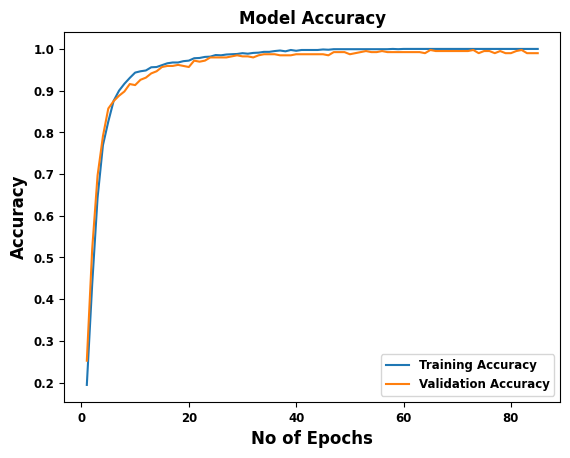

In [31]:
epochs = np.arange(1,86,1)

plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Accuracy",fontsize=12,fontweight='bold')
plt.title("Model Accuracy",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('vgg_16_model_accuracy')
plt.show()

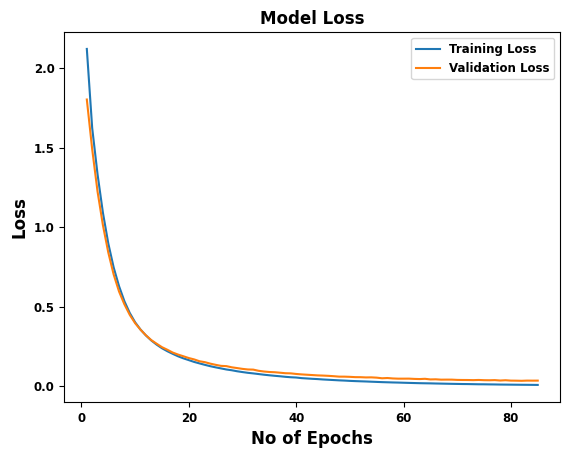

In [32]:
epochs = np.arange(1,86,1)

plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Loss",fontsize=12,fontweight='bold')
plt.title("Model Loss",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('vgg16_model_loss')
plt.show()

In [16]:
model_new.load_weights("best_model_spectogram_vgg16.h5")

In [21]:
model_new.evaluate(X_Test,Y_Test)

18/18 [==============================] - 29s 1s/step - loss: 0.0499 - accuracy: 0.9875


[0.049931600689888, 0.987500011920929]

### Confusion Matrix

In [17]:
predict_x = model_new.predict(X_Test)
Y_Pred = np.argmax(predict_x,axis=1)

18/18 [==============================] - 25s 1s/step


In [18]:
Y_actual = np.argmax(Y_Test,axis=1)
cnf_matrix = confusion_matrix(Y_actual,Y_Pred)
print(cnf_matrix)

[[80  0  0  0  0  0  0]
 [ 0 86  0  0  0  1  0]
 [ 0  0 78  0  0  0  0]
 [ 0  0  1 79  0  0  0]
 [ 1  0  0  0 85  0  0]
 [ 0  0  0  1  0 74  0]
 [ 0  0  0  0  3  0 71]]


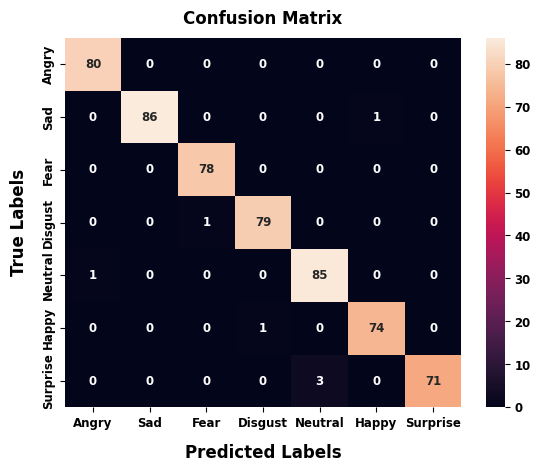

In [37]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted Labels',fontsize=12,fontweight='bold',labelpad=10);
ax.set_ylabel('True Labels',fontsize=12,fontweight='bold',labelpad=10); 
ax.set_title('Confusion Matrix',fontsize=12,fontweight='bold',pad=10); 
ax.xaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']); ax.yaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']);
plt.savefig('vgg16_confusion_matrix')

### Classification Report

In [19]:
print(classification_report(Y_actual, Y_Pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        80
           1       1.00      0.99      0.99        87
           2       0.99      1.00      0.99        78
           3       0.99      0.99      0.99        80
           4       0.97      0.99      0.98        86
           5       0.99      0.99      0.99        75
           6       1.00      0.96      0.98        74

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



### Sensitivity and Specificity

In [20]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

In [21]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [22]:
TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
ACC = (TP+TN)/(TP+FP+FN+TN)
FPR = FP/(FP+TN)

In [23]:
print("Sensitivity = ",TPR)
print("Specificity = ",TNR)
print("accuracy for each class = ",ACC)

Sensitivity =  [1.         0.98850575 1.         0.9875     0.98837209 0.98666667
 0.95945946]
Specificity =  [0.99791667 1.         0.99792531 0.99791667 0.99367089 0.99793814
 1.        ]
accuracy for each class =  [0.99821429 0.99821429 0.99821429 0.99642857 0.99285714 0.99642857
 0.99464286]


### ROC Curve 

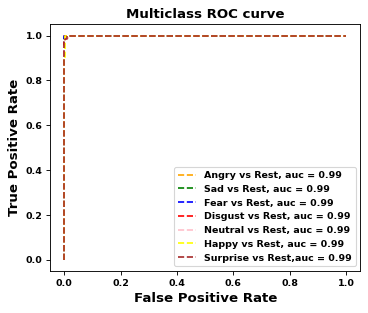

In [24]:
### ROC Curve
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
auc = {}
y_prob_pred_cnb = predict_x

n_class = 7
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(Y_actual, y_prob_pred_cnb[:,i], pos_label=i)
    auc[i] = metrics.roc_auc_score(Y_actual,y_prob_pred_cnb,multi_class='ovr',average='weighted')
plt.figure(figsize=(5, 4),dpi=80)    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Angry vs Rest, auc = '+str(auc[0])[:4])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Sad vs Rest, auc = '+str(auc[1])[:4])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Fear vs Rest, auc = '+str(auc[2])[:4])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Disgust vs Rest, auc = '+str(auc[3])[:4])
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Neutral vs Rest, auc = '+str(auc[4])[:4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='yellow', label='Happy vs Rest, auc = '+str(auc[5])[:4])
plt.plot(fpr[6], tpr[6], linestyle='--',color='brown', label='Surprise vs Rest,auc = '+str(auc[6])[:4])
plt.title('Multiclass ROC curve',fontsize=12,fontweight='bold')
plt.xlabel('False Positive Rate',fontsize=12,fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=12,fontweight='bold')
plt.legend(loc='best')
plt.savefig('vgg16_Multiclass_ROC',dpi=80);    

### Using VGG-19

In [25]:
model = VGG19(weights='imagenet',include_top=False,input_shape=(128,130,3))

In [26]:
model.trainable = False

In [27]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 130, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 130, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 130, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 65, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 65, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 65, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [28]:
#Functional API
av1 = GlobalAveragePooling2D()(model.output)
dl1 = Dense(256,activation='relu')(av1)
dl2 = Dense(128,activation='relu')(dl1)
dl3 = Dense(7,activation='softmax')(dl2)

model_new = Model(inputs=model.input,outputs=dl3)
model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 130, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 130, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 130, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 65, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 65, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 65, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [29]:
adam = Adam(lr=0.00003)
model_new.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [30]:
early_stop=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
best_model = ModelCheckpoint('./best_model_spectogram_vgg19.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
hist = model_new.fit(X_Train,Y_Train,shuffle=True,batch_size=20,epochs=100,validation_split=0.20,callbacks=[early_stop,best_model])

In [31]:
with open('saved_hist_spectogram_vgg19.pkl', 'rb') as f:
    loaded_hist = pickle.load(f)

In [32]:
history = loaded_hist

In [33]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

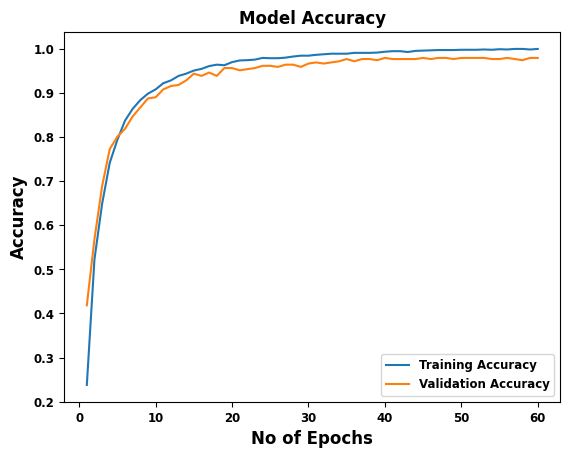

In [54]:
epochs = np.arange(1,61,1)

plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Accuracy",fontsize=12,fontweight='bold')
plt.title("Model Accuracy",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('vgg19_model_accuracy')
plt.show()

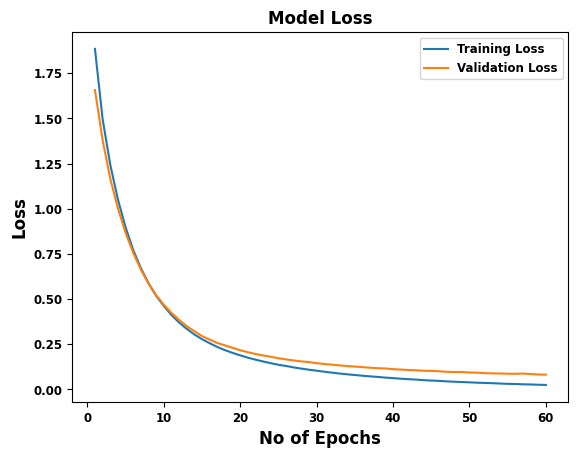

In [55]:
epochs = np.arange(1,61,1)

plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Loss",fontsize=12,fontweight='bold')
plt.title("Model Loss",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('vgg19_model_loss')
plt.show()

In [32]:
model_new.load_weights("best_model_spectogram_vgg19.h5")

In [33]:
model_new.evaluate(X_Test,Y_Test)

18/18 [==============================] - 34s 2s/step - loss: 0.1045 - accuracy: 0.9714


[0.10451814532279968, 0.9714285731315613]

### Confusion Matrix

In [34]:
predict_x = model_new.predict(X_Test)
Y_Pred = np.argmax(predict_x,axis=1)

18/18 [==============================] - 39s 2s/step


In [35]:
Y_actual = np.argmax(Y_Test,axis=1)
cnf_matrix = confusion_matrix(Y_actual,Y_Pred)
print(cnf_matrix)

[[77  0  3  0  0  0  0]
 [ 0 87  0  0  0  0  0]
 [ 0  0 78  0  0  0  0]
 [ 0  1  1 75  0  3  0]
 [ 0  0  0  0 85  0  1]
 [ 0  2  0  0  0 73  0]
 [ 0  1  0  0  4  0 69]]


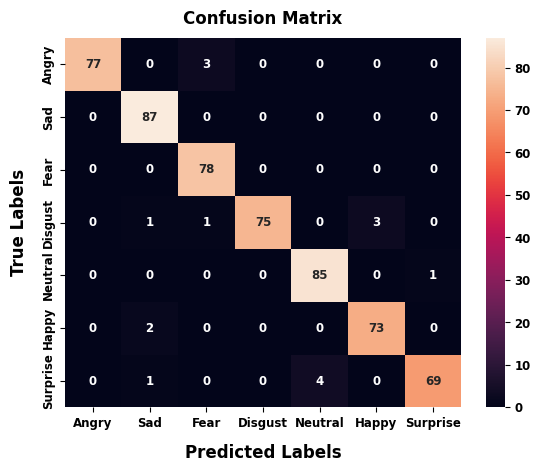

In [60]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted Labels',fontsize=12,fontweight='bold',labelpad=10);
ax.set_ylabel('True Labels',fontsize=12,fontweight='bold',labelpad=10); 
ax.set_title('Confusion Matrix',fontsize=12,fontweight='bold',pad=10); 
ax.xaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']); ax.yaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']);
plt.savefig('vgg19_confusion_matrix')

### Classification Report

In [36]:
print(classification_report(Y_actual, Y_Pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        80
           1       0.96      1.00      0.98        87
           2       0.95      1.00      0.97        78
           3       1.00      0.94      0.97        80
           4       0.96      0.99      0.97        86
           5       0.96      0.97      0.97        75
           6       0.99      0.93      0.96        74

    accuracy                           0.97       560
   macro avg       0.97      0.97      0.97       560
weighted avg       0.97      0.97      0.97       560



### Sensitivity and Specificity

In [37]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

In [38]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [39]:
TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
ACC = (TP+TN)/(TP+FP+FN+TN)
FPR = FP/(FP+TN)

In [40]:
print("Sensitivity = ",TPR)
print("Specificity = ",TNR)
print("accuracy for each class = ",ACC)

Sensitivity =  [0.9625     1.         1.         0.9375     0.98837209 0.97333333
 0.93243243]
Specificity =  [1.         0.99154334 0.99170124 1.         0.99156118 0.99381443
 0.99794239]
accuracy for each class =  [0.99464286 0.99285714 0.99285714 0.99107143 0.99107143 0.99107143
 0.98928571]


### ROC Curve 

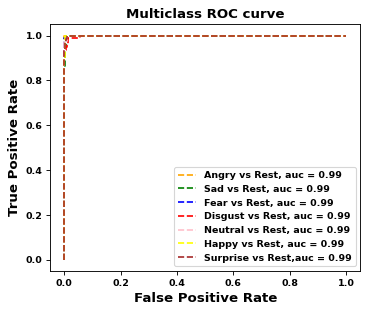

In [42]:
### ROC Curve
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
auc = {}
y_prob_pred_cnb = predict_x

n_class = 7
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(Y_actual, y_prob_pred_cnb[:,i], pos_label=i)
    auc[i] = metrics.roc_auc_score(Y_actual,y_prob_pred_cnb,multi_class='ovr',average='weighted')

plt.figure(figsize=(5, 4),dpi=80)  
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Angry vs Rest, auc = '+str(auc[0])[:4])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Sad vs Rest, auc = '+str(auc[1])[:4])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Fear vs Rest, auc = '+str(auc[2])[:4])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Disgust vs Rest, auc = '+str(auc[3])[:4])
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Neutral vs Rest, auc = '+str(auc[4])[:4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='yellow', label='Happy vs Rest, auc = '+str(auc[5])[:4])
plt.plot(fpr[6], tpr[6], linestyle='--',color='brown', label='Surprise vs Rest,auc = '+str(auc[6])[:4])
plt.title('Multiclass ROC curve',fontsize=12,fontweight='bold')
plt.xlabel('False Positive Rate',fontsize=12,fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=12,fontweight='bold')
plt.legend(loc='best')
plt.savefig('vgg19_Multiclass_ROC',dpi=80);    

### Using Resnet50

In [35]:
model = ResNet50(include_top=False,weights='imagenet',input_shape=(128,130,3))

In [36]:
# Functional API
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(256,activation='relu')(av1)
d1 = Dropout(0.5)(fc1)
fc2 = Dense(7,activation='softmax')(d1)

model_new = Model(inputs=model.input,outputs=fc2)
model_new.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 130, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 136, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 65, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 65, 64)   256         ['conv1_conv[0][0]']       

 conv2_block3_2_conv (Conv2D)   (None, 32, 33, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 33, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 33, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 33, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 17, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 17, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 17, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 17, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 9, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 9, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 9, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 9, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 9, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 9, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 9, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 9, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 5, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 5, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 5, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 5, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [37]:
adam = Adam(lr=0.00003)
model_new.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [38]:
early_stop=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
best_model = ModelCheckpoint('./best_model_spectogram/resnet50.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [39]:
# Perform Fine Tuning -> Train only the few layers at the last
for ix in range(169):
    model_new.layers[ix].trainable = False

In [ ]:
hist = model_new.fit(X_Train,Y_Train,shuffle=True,batch_size=20,epochs=200,validation_data = (X_Validation,Y_Validation),callbacks=[early_stop,best_model])

In [40]:
with open('saved_hist_spectogram_resnet50.pkl', 'rb') as f:
    loaded_hist = pickle.load(f)

In [41]:
history = loaded_hist

In [42]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

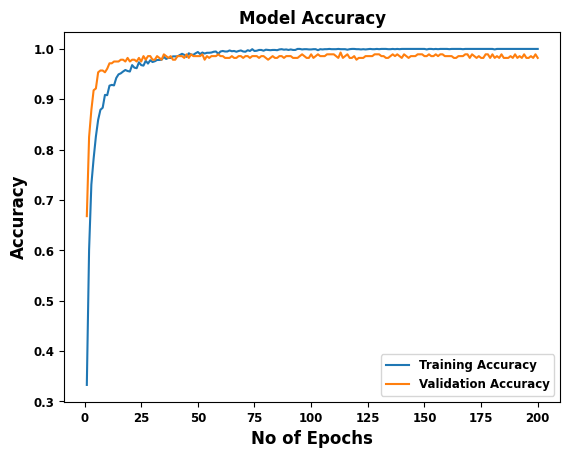

In [76]:
epochs = np.arange(1,201,1)

plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Accuracy",fontsize=12,fontweight='bold')
plt.title("Model Accuracy",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('resnet_50_model_accuracy')
plt.show()

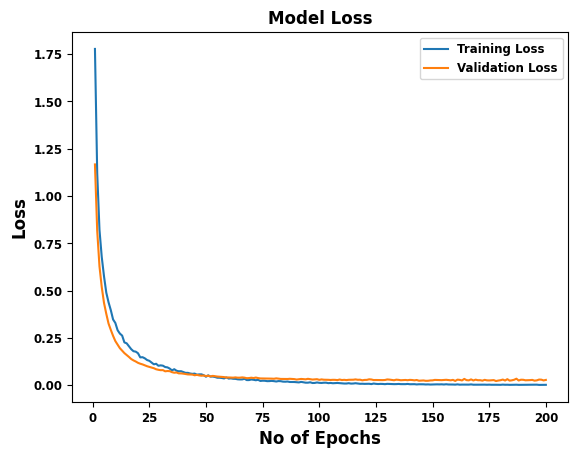

In [77]:
epochs = np.arange(1,201,1)

plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Loss",fontsize=12,fontweight='bold')
plt.title("Model Loss",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('resnet50_model_loss')
plt.show()

In [15]:
model_new.load_weights("best_model_spectogram_resnet50.h5")

In [16]:
model_new.evaluate(X_Test,Y_Test)

18/18 [==============================] - 13s 497ms/step - loss: 0.0402 - accuracy: 0.9875


[0.04024316743016243, 0.987500011920929]

### Confusion Matrix

In [17]:
predict_x = model_new.predict(X_Test)
Y_Pred = np.argmax(predict_x,axis=1)

18/18 [==============================] - 10s 496ms/step


In [18]:
Y_actual = np.argmax(Y_Test,axis=1)
cnf_matrix = confusion_matrix(Y_actual,Y_Pred)
print(cnf_matrix)

[[80  0  0  0  0  0  0]
 [ 0 87  0  0  0  0  0]
 [ 1  0 77  0  0  0  0]
 [ 2  0  0 77  0  1  0]
 [ 0  0  0  0 85  0  1]
 [ 0  0  0  1  0 74  0]
 [ 0  0  0  0  1  0 73]]


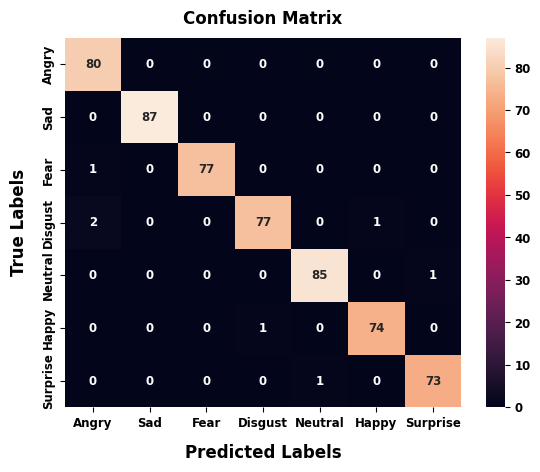

In [82]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted Labels',fontsize=12,fontweight='bold',labelpad=10);
ax.set_ylabel('True Labels',fontsize=12,fontweight='bold',labelpad=10); 
ax.set_title('Confusion Matrix',fontsize=12,fontweight='bold',pad=10); 
ax.xaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']); ax.yaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']);
plt.savefig('resnet50_confusion_matrix')

### Classification Report

In [19]:
print(classification_report(Y_actual, Y_Pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        80
           1       1.00      1.00      1.00        87
           2       1.00      0.99      0.99        78
           3       0.99      0.96      0.97        80
           4       0.99      0.99      0.99        86
           5       0.99      0.99      0.99        75
           6       0.99      0.99      0.99        74

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



### Sensitivity and Specificity

In [20]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

In [21]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [22]:
TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
ACC = (TP+TN)/(TP+FP+FN+TN)
FPR = FP/(FP+TN)

In [23]:
print("Sensitivity = ",TPR)
print("Specificity = ",TNR)
print("accuracy for each class = ",ACC)

Sensitivity =  [1.         1.         0.98717949 0.9625     0.98837209 0.98666667
 0.98648649]
Specificity =  [0.99375    1.         1.         0.99791667 0.9978903  0.99793814
 0.99794239]
accuracy for each class =  [0.99464286 1.         0.99821429 0.99285714 0.99642857 0.99642857
 0.99642857]


### ROC Curve

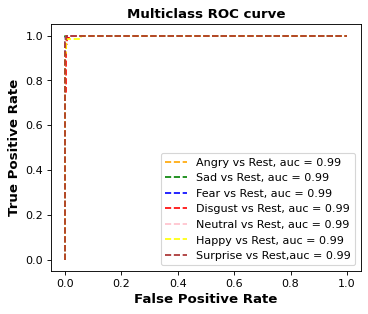

In [24]:
### ROC Curve
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
auc = {}
y_prob_pred_cnb = predict_x

n_class = 7
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(Y_actual, y_prob_pred_cnb[:,i], pos_label=i)
    auc[i] = metrics.roc_auc_score(Y_actual,y_prob_pred_cnb,multi_class='ovr',average='weighted')
plt.figure(figsize=(5, 4),dpi=80)     
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Angry vs Rest, auc = '+str(auc[0])[:4])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Sad vs Rest, auc = '+str(auc[1])[:4])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Fear vs Rest, auc = '+str(auc[2])[:4])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Disgust vs Rest, auc = '+str(auc[3])[:4])
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Neutral vs Rest, auc = '+str(auc[4])[:4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='yellow', label='Happy vs Rest, auc = '+str(auc[5])[:4])
plt.plot(fpr[6], tpr[6], linestyle='--',color='brown', label='Surprise vs Rest,auc = '+str(auc[6])[:4])
plt.title('Multiclass ROC curve',fontsize=12,fontweight='bold')
plt.xlabel('False Positive Rate',fontsize=12,fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=12,fontweight='bold')
plt.legend(loc='best')
plt.savefig('resnet50_Multiclass_ROC',dpi=80);    

## Using RNN+BiLSTM

In [45]:
X = X.reshape((2800,128,130)) # Initially it was (2800,128,130,1). We need to remove 3rd dimension.
print(X.shape,Y.shape)

(2800, 128, 130) (2800, 7)


In [46]:
X_Train,X_Test,Y_Train,Y_Test = train_test_split(X,Y,random_state=1,shuffle=True,test_size=0.2)
X_Train,X_Validation,Y_Train,Y_Validation = train_test_split(X_Train,Y_Train,random_state=2,shuffle=True,test_size=0.125)
print(X_Train.shape,Y_Train.shape)
print(X_Test.shape,Y_Test.shape)
print(X_Validation.shape,Y_Validation.shape)

(1960, 128, 130) (1960, 7)
(560, 128, 130) (560, 7)
(280, 128, 130) (280, 7)


In [74]:
model = Sequential()
model.add(SimpleRNN(64,input_shape=(128,130)))
model.add(Reshape((64, 1), input_shape=(64,)))
model.add(Bidirectional(LSTM(128,return_sequences=False)))
model.add(Dense(32,activation='relu'))
model.add(Dense(7,activation='softmax'))
adam = Adam(lr=0.003)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [48]:
## Train the model
best_model = ModelCheckpoint('./best_model_spectogram_rnn_lstm.h5', monitor='val_accuracy', mode='max', save_best_only=True)
history = model.fit(X_Train,Y_Train,validation_data=(X_Validation,Y_Validation),epochs=60,batch_size=16,shuffle=True,callbacks=[best_model])

Epoch 1/60
123/123 [==============================] - 13s 54ms/step - loss: 1.9479 - accuracy: 0.1459 - val_loss: 1.9493 - val_accuracy: 0.1250
Epoch 2/60
123/123 [==============================] - 5s 41ms/step - loss: 1.9460 - accuracy: 0.1480 - val_loss: 1.9523 - val_accuracy: 0.1250
Epoch 3/60
123/123 [==============================] - 8s 63ms/step - loss: 1.9459 - accuracy: 0.1403 - val_loss: 1.9518 - val_accuracy: 0.1250
Epoch 4/60
123/123 [==============================] - 8s 66ms/step - loss: 1.9461 - accuracy: 0.1495 - val_loss: 1.9517 - val_accuracy: 0.1250
Epoch 5/60
123/123 [==============================] - 8s 61ms/step - loss: 1.9463 - accuracy: 0.1383 - val_loss: 1.9520 - val_accuracy: 0.1250
Epoch 6/60
123/123 [==============================] - 8s 62ms/step - loss: 1.9458 - accuracy: 0.1423 - val_loss: 1.9523 - val_accuracy: 0.1250
Epoch 7/60
123/123 [==============================] - 8s 62ms/step - loss: 1.9460 - accuracy: 0.1469 - val_loss: 1.9506 - val_accuracy: 0.107

Epoch 58/60
123/123 [==============================] - 8s 62ms/step - loss: 1.9455 - accuracy: 0.1510 - val_loss: 1.9518 - val_accuracy: 0.1071
Epoch 59/60
123/123 [==============================] - 8s 61ms/step - loss: 1.9455 - accuracy: 0.1510 - val_loss: 1.9521 - val_accuracy: 0.1071
Epoch 60/60
123/123 [==============================] - 8s 62ms/step - loss: 1.9455 - accuracy: 0.1510 - val_loss: 1.9522 - val_accuracy: 0.1071


In [49]:
with open('saved_hist_spectrogram_rnn_bilstm.pkl','wb') as f:
    pickle.dump(history.history,f)

In [75]:
with open('saved_hist_spectrogram_rnn_bilstm.pkl','rb') as f:
    history = pickle.load(f)

## Plot the Results

In [76]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

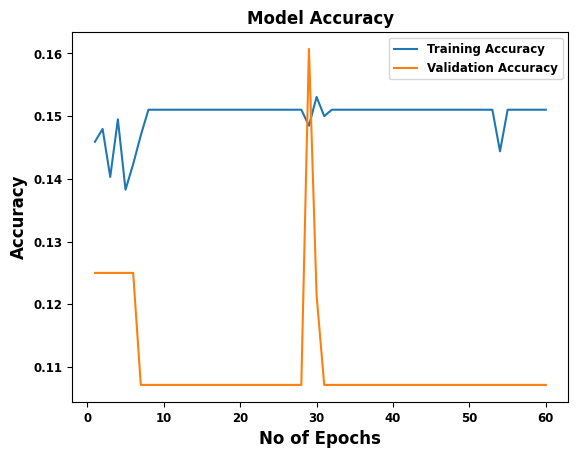

In [77]:
epochs = np.arange(1,61,1)
plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Accuracy",fontsize=12,fontweight='bold')
plt.title("Model Accuracy",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('RNN_BiLSTM_model_accuracy')
plt.show()

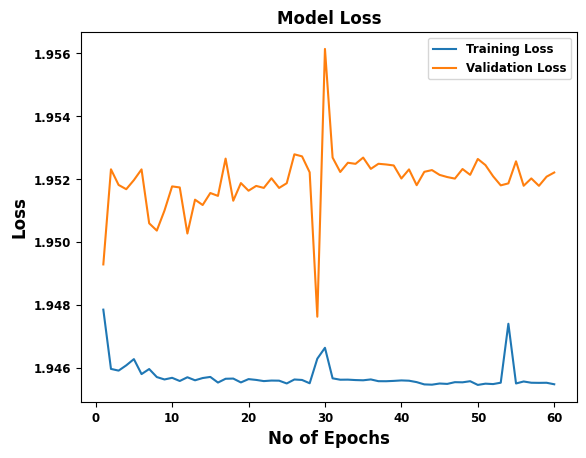

In [78]:
epochs = np.arange(1,61,1)
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Loss",fontsize=12,fontweight='bold')
plt.title("Model Loss",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('RNN_BiLSTM_model_loss')
plt.show()

In [79]:
model.load_weights('best_model_spectogram_rnn_lstm.h5')

In [80]:
model.evaluate(X_Test,Y_Test)

18/18 [==============================] - 3s 16ms/step - loss: 1.9509 - accuracy: 0.1429


[1.950858473777771, 0.1428571492433548]

## Confusion Matrix

In [81]:
predict_x = model.predict(X_Test)
Y_Pred = np.argmax(predict_x,axis=1)

18/18 [==============================] - 1s 16ms/step


In [82]:
Y_actual = np.argmax(Y_Test,axis=1)
cnf_matrix = confusion_matrix(Y_actual,Y_Pred)
print(cnf_matrix)  

[[ 0  0  0 80  0  0  0]
 [ 0  0  0 87  0  0  0]
 [ 0  0  0 78  0  0  0]
 [ 0  0  0 80  0  0  0]
 [ 0  0  0 86  0  0  0]
 [ 0  0  0 75  0  0  0]
 [ 0  0  0 74  0  0  0]]


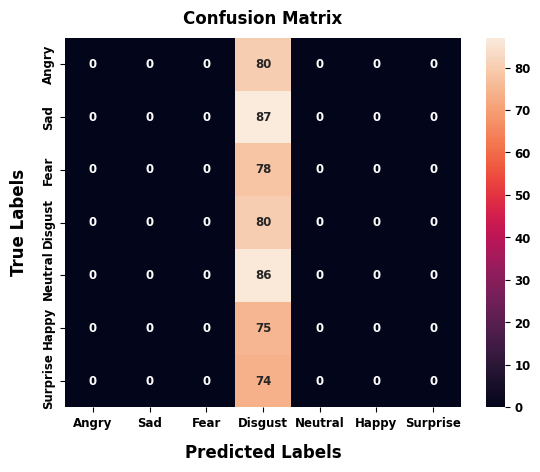

In [83]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted Labels',fontsize=12,fontweight='bold',labelpad=10);
ax.set_ylabel('True Labels',fontsize=12,fontweight='bold',labelpad=10); 
ax.set_title('Confusion Matrix',fontsize=12,fontweight='bold',pad=10); 
ax.xaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']); ax.yaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']);
plt.savefig('RNN_BiLSTM_confusion_matrix')

### Classification Report

In [71]:
print(classification_report(Y_actual, Y_Pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.00      0.00      0.00        87
           2       0.00      0.00      0.00        78
           3       0.14      1.00      0.25        80
           4       0.00      0.00      0.00        86
           5       0.00      0.00      0.00        75
           6       0.00      0.00      0.00        74

    accuracy                           0.14       560
   macro avg       0.02      0.14      0.04       560
weighted avg       0.02      0.14      0.04       560



/home/workspace/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/workspace/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/workspace/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### Sensitivity and Specificity

In [84]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

In [85]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [86]:
TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
ACC = (TP+TN)/(TP+FP+FN+TN)
FPR = FP/(FP+TN)

In [87]:
print("Sensitivity = ",TPR)
print("Specificity = ",TNR)
print("accuracy for each class = ",ACC)

Sensitivity =  [0. 0. 0. 1. 0. 0. 0.]
Specificity =  [1. 1. 1. 0. 1. 1. 1.]
accuracy for each class =  [0.85714286 0.84464286 0.86071429 0.14285714 0.84642857 0.86607143
 0.86785714]


## ROC Curve

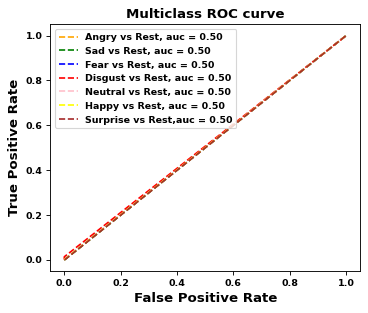

In [88]:
### ROC Curve
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
auc = {}
y_prob_pred_cnb = predict_x

n_class = 7
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(Y_actual, y_prob_pred_cnb[:,i], pos_label=i)
    auc[i] = metrics.roc_auc_score(Y_actual,y_prob_pred_cnb,multi_class='ovr',average='weighted')
plt.figure(figsize=(5, 4),dpi=80)      
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Angry vs Rest, auc = '+str(auc[0])[:4])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Sad vs Rest, auc = '+str(auc[1])[:4])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Fear vs Rest, auc = '+str(auc[2])[:4])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Disgust vs Rest, auc = '+str(auc[3])[:4])
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Neutral vs Rest, auc = '+str(auc[4])[:4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='yellow', label='Happy vs Rest, auc = '+str(auc[5])[:4])
plt.plot(fpr[6], tpr[6], linestyle='--',color='brown', label='Surprise vs Rest,auc = '+str(auc[6])[:4])
plt.title('Multiclass ROC curve',fontsize=12,fontweight='bold')
plt.xlabel('False Positive Rate',fontsize=12,fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=12,fontweight='bold')
plt.legend(loc='best')
plt.savefig('RNN_BiLSTM_Multiclass_ROC',dpi=80);    

## Using DNN+BiLSTM

In [64]:
model = Sequential()
model.add(Dense(256,activation='relu',input_shape=(128,130)))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dense(16,activation='relu'))
model.add(Dense(7,activation='softmax'))

In [65]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [66]:
## Train the model
best_model = ModelCheckpoint('./best_model_spectogram_dnn_lstm.h5', monitor='val_accuracy', mode='max', save_best_only=True)
history = model.fit(X_Train,Y_Train,validation_data=(X_Validation,Y_Validation),epochs=100,batch_size=16,shuffle=True,callbacks=[best_model])

Epoch 1/100
123/123 [==============================] - 10s 63ms/step - loss: 1.8659 - accuracy: 0.2694 - val_loss: 1.7009 - val_accuracy: 0.4357
Epoch 2/100
123/123 [==============================] - 10s 77ms/step - loss: 1.4992 - accuracy: 0.5128 - val_loss: 1.3071 - val_accuracy: 0.5679
Epoch 3/100
123/123 [==============================] - 11s 86ms/step - loss: 1.0546 - accuracy: 0.6571 - val_loss: 0.8267 - val_accuracy: 0.6643
Epoch 4/100
123/123 [==============================] - 10s 82ms/step - loss: 0.8074 - accuracy: 0.7245 - val_loss: 0.7200 - val_accuracy: 0.7071
Epoch 5/100
123/123 [==============================] - 10s 85ms/step - loss: 0.6344 - accuracy: 0.7837 - val_loss: 0.6974 - val_accuracy: 0.7214
Epoch 6/100
123/123 [==============================] - 12s 100ms/step - loss: 0.5590 - accuracy: 0.7913 - val_loss: 0.5278 - val_accuracy: 0.7857
Epoch 7/100
123/123 [==============================] - 11s 92ms/step - loss: 0.5002 - accuracy: 0.8214 - val_loss: 0.5448 - val_a

123/123 [==============================] - 10s 78ms/step - loss: 0.1872 - accuracy: 0.9393 - val_loss: 0.1975 - val_accuracy: 0.9429
Epoch 58/100
123/123 [==============================] - 9s 77ms/step - loss: 0.2153 - accuracy: 0.9265 - val_loss: 0.3862 - val_accuracy: 0.8679
Epoch 59/100
123/123 [==============================] - 10s 78ms/step - loss: 0.2549 - accuracy: 0.9128 - val_loss: 0.2721 - val_accuracy: 0.9071
Epoch 60/100
123/123 [==============================] - 10s 84ms/step - loss: 0.1926 - accuracy: 0.9383 - val_loss: 0.3067 - val_accuracy: 0.8893
Epoch 61/100
123/123 [==============================] - 10s 82ms/step - loss: 0.3501 - accuracy: 0.8730 - val_loss: 0.3658 - val_accuracy: 0.8714
Epoch 62/100
123/123 [==============================] - 10s 79ms/step - loss: 0.2217 - accuracy: 0.9199 - val_loss: 0.2562 - val_accuracy: 0.9107
Epoch 63/100
123/123 [==============================] - 10s 78ms/step - loss: 0.1731 - accuracy: 0.9408 - val_loss: 0.2798 - val_accuracy:

In [67]:
with open('saved_hist_spectrogram_dnn_bilstm.pkl','wb') as f:
    pickle.dump(history.history,f)

In [68]:
with open('saved_hist_spectrogram_dnn_bilstm.pkl','rb') as f:
    history = pickle.load(f)

## Plot the Results

In [69]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

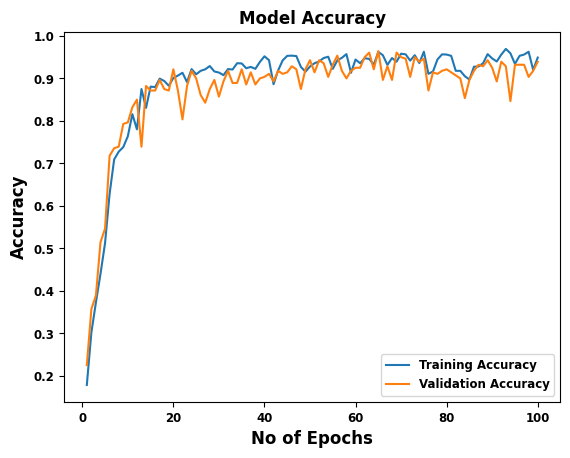

In [44]:
epochs = np.arange(1,101,1)
plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Accuracy",fontsize=12,fontweight='bold')
plt.title("Model Accuracy",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('DNN_BiLSTM_model_accuracy')
plt.show()

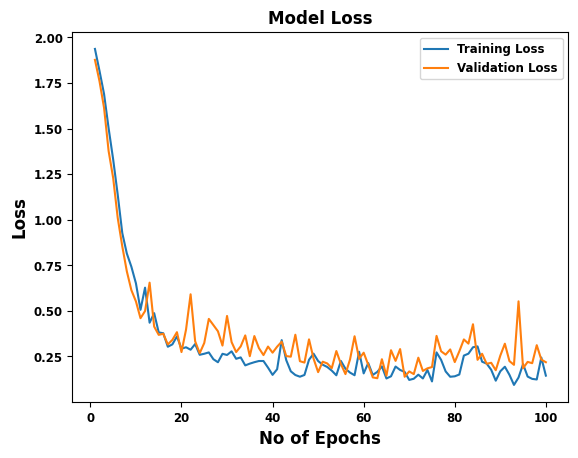

In [45]:
epochs = np.arange(1,101,1)
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.xlabel("No of Epochs",fontsize=12,fontweight='bold')
plt.ylabel("Loss",fontsize=12,fontweight='bold')
plt.title("Model Loss",fontsize=12,fontweight='bold')
plt.legend()
plt.savefig('DNN_BiLSTM_model_loss')
plt.show()

In [33]:
model.load_weights('best_model_spectogram_dnn_lstm.h5')

In [33]:
model.evaluate(X_Test,Y_Test)

18/18 [==============================] - 0s 15ms/step - loss: 0.1703 - accuracy: 0.9339


[0.17031238973140717, 0.9339285492897034]

## Confusion Matrix

In [34]:
predict_x = model.predict(X_Test)
Y_Pred = np.argmax(predict_x,axis=1)

18/18 [==============================] - 3s 17ms/step


In [35]:
Y_actual = np.argmax(Y_Test,axis=1)
cnf_matrix = confusion_matrix(Y_actual,Y_Pred)
print(cnf_matrix)  

[[71  0  8  1  0  0  0]
 [ 0 84  0  2  0  1  0]
 [ 0  0 75  0  0  3  0]
 [ 0  1  0 73  0  6  0]
 [ 0  2  0  0 83  1  0]
 [ 0  1  1  4  1 68  0]
 [ 1  2  1  1  0  0 69]]


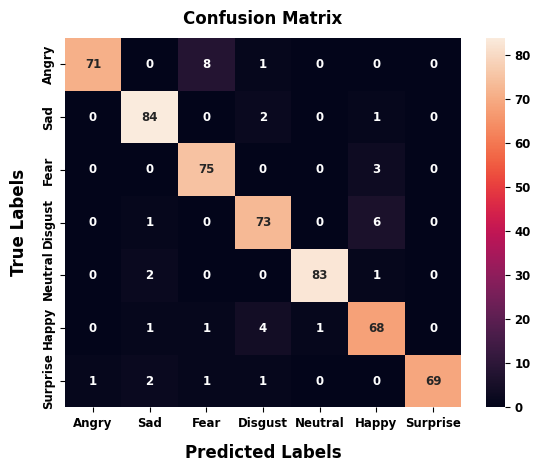

In [46]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted Labels',fontsize=12,fontweight='bold',labelpad=10);
ax.set_ylabel('True Labels',fontsize=12,fontweight='bold',labelpad=10); 
ax.set_title('Confusion Matrix',fontsize=12,fontweight='bold',pad=10); 
ax.xaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']); ax.yaxis.set_ticklabels(['Angry','Sad','Fear','Disgust','Neutral','Happy','Surprise']);
plt.savefig('DNN_BiLSTM_confusion_matrix')

### Classification Report

In [36]:
print(classification_report(Y_actual, Y_Pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93        80
           1       0.93      0.97      0.95        87
           2       0.88      0.96      0.92        78
           3       0.90      0.91      0.91        80
           4       0.99      0.97      0.98        86
           5       0.86      0.91      0.88        75
           6       1.00      0.93      0.97        74

    accuracy                           0.93       560
   macro avg       0.94      0.93      0.93       560
weighted avg       0.94      0.93      0.93       560



### Sensitivity and Specificity

In [37]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

In [38]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [39]:
TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
ACC = (TP+TN)/(TP+FP+FN+TN)
FPR = FP/(FP+TN)

In [40]:
print("Sensitivity = ",TPR)
print("Specificity = ",TNR)
print("accuracy for each class = ",ACC)

Sensitivity =  [0.8875     0.96551724 0.96153846 0.9125     0.96511628 0.90666667
 0.93243243]
Specificity =  [0.99791667 0.98731501 0.97925311 0.98333333 0.9978903  0.97731959
 1.        ]
accuracy for each class =  [0.98214286 0.98392857 0.97678571 0.97321429 0.99285714 0.96785714
 0.99107143]


## ROC Curve

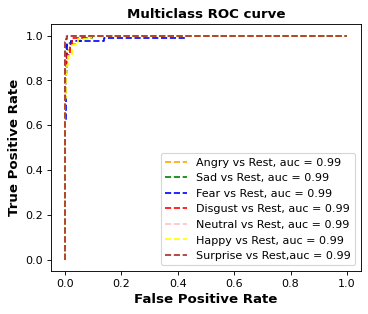

In [41]:
### ROC Curve
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
auc = {}
y_prob_pred_cnb = predict_x

n_class = 7
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(Y_actual, y_prob_pred_cnb[:,i], pos_label=i)
    auc[i] = metrics.roc_auc_score(Y_actual,y_prob_pred_cnb,multi_class='ovr',average='weighted')
plt.figure(figsize=(5, 4),dpi=80)      
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Angry vs Rest, auc = '+str(auc[0])[:4])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Sad vs Rest, auc = '+str(auc[1])[:4])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Fear vs Rest, auc = '+str(auc[2])[:4])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Disgust vs Rest, auc = '+str(auc[3])[:4])
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Neutral vs Rest, auc = '+str(auc[4])[:4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='yellow', label='Happy vs Rest, auc = '+str(auc[5])[:4])
plt.plot(fpr[6], tpr[6], linestyle='--',color='brown', label='Surprise vs Rest,auc = '+str(auc[6])[:4])
plt.title('Multiclass ROC curve',fontsize=12,fontweight='bold')
plt.xlabel('False Positive Rate',fontsize=12,fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=12,fontweight='bold')
plt.legend(loc='best')
plt.savefig('DNN_BiLSTM_Multiclass_ROC',dpi=80);    